# Best classifiers for DGA-Detector


In [ ]:
"""
 * @file DGA-Detector-Best-Classifiers.ipynb
 * @brief Implements the best classifiers for detecting Domain Generation Algorithms (DGA) using machine learning techniques.

 * This Jupyter notebook contains the implementation and evaluation of two advanced classifiers: LightGBM and a Neural Network model. The goal of these classifiers is to accurately identify DGA traffic, which is crucial for enhancing cybersecurity measures against malicious activities.

 * The main functionalities of this notebook include:
 * - Loading and preprocessing of domain name data sets labeled as 'DGA' and 'benign'.
 * - Subsampling of the data to manage computational resources effectively.
 * - Feature extraction and selection for the machine learning models.
 * - Splitting the data into training and testing sets to ensure model validation.
 * - Training LightGBM and Neural Network models using cross-validation to optimize parameters and prevent overfitting.
 * - Evaluating model performance with metrics such as Precision, Recall, F1-Score, and ROC-AUC.
 * - Displaying results through confusion matrices and ROC curves to provide clear visual insights into model effectiveness.
 * - Handling data imbalances and computational efficiency through various techniques like subsampling and parallel processing.

 * @version 1.0
 * @date 2024-03-22
 * @author Matej Keznikl (matej.keznikl@gmail.com)
 * @copyright Copyright (c) 2024
 *
"""

## Loading data


In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

dga = pq.read_table("floor/02-Preprocessed-data/DGA/01-DGA-Features.parquet")
benign = pq.read_table("floor/02-Preprocessed-data/Benign/00-Benign-Features.parquet")

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(dga.schema)

dga = dga.append_column("label", pa.array(["dga"] * len(dga)))
benign = benign.append_column("label", pa.array(["benign"] * len(benign)))

dga = dga.drop(["domain_name"])
benign = benign.drop(["domain_name"])

# concatentate tables
data = pa.concat_tables([dga, benign])
df = data.to_pandas()

print("Features:")
for feature in df.columns:
    print(feature)

# Handle NaNs
df.fillna(-1, inplace=True)

df

Features:
lex_name_len
lex_has_digit
lex_phishing_keyword_count
lex_consecutive_chars
lex_tld_len
lex_tld_abuse_score
lex_sld_len
lex_sld_norm_entropy
lex_sld_digit_count
lex_sld_digit_ratio
lex_sld_phishing_keyword_count
lex_sld_vowel_count
lex_sld_vowel_ratio
lex_sld_consonant_count
lex_sld_consonant_ratio
lex_sld_non_alphanum_count
lex_sld_non_alphanum_ratio
lex_sld_hex_count
lex_sld_hex_ratio
lex_sub_count
lex_stld_unique_char_count
lex_begins_with_digit
lex_sub_max_consonant_len
lex_sub_norm_entropy
lex_sub_digit_count
lex_sub_digit_ratio
lex_sub_vowel_count
lex_sub_vowel_ratio
lex_sub_consonant_count
lex_sub_consonant_ratio
lex_sub_non_alphanum_count
lex_sub_non_alphanum_ratio
lex_sub_hex_count
lex_sub_hex_ratio
lex_dga_bigram_matches
lex_dga_trigram_matches
lex_dga_tetragram_matches
lex_dga_pentagram_matches
mod_jaccard_bi-grams_benign
mod_jaccard_tri-grams_benign
mod_jaccard_penta-grams_benign
mod_jaccard_bi-grams_dga
mod_jaccard_tri-grams_dga
mod_jaccard_penta-grams_dga
lex_av

,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,...,mod_jaccard_tri-grams_benign,mod_jaccard_penta-grams_benign,mod_jaccard_bi-grams_dga,mod_jaccard_tri-grams_dga,mod_jaccard_penta-grams_dga,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_shortest_sub_len,label
0,15,0,0,2,2,0.0000,12,0.237949,0.0,0.000000,...,0.538462,0.000000,0.857143,0.076923,0.000000,7.000000,0.500000,12,12,dga
1,31,1,0,2,3,0.0081,27,0.151053,9.0,0.333333,...,0.172414,0.000000,0.900000,0.137931,0.074074,15.000000,0.500000,27,27,dga
2,19,0,0,1,3,0.6554,15,0.221549,0.0,0.000000,...,0.411765,0.133333,0.888889,0.529412,0.000000,9.000000,0.500000,15,15,dga
3,13,0,1,1,4,0.0043,8,0.375000,0.0,0.000000,...,0.454545,0.222222,0.833333,0.272727,0.111111,6.000000,0.500000,8,8,dga
4,30,1,0,1,3,0.0081,26,0.165993,8.0,0.307692,...,0.142857,0.000000,0.689655,0.107143,0.000000,14.500000,0.500000,26,26,dga
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691813,15,0,0,2,10,0.0000,4,0.375000,0.0,0.000000,...,0.615385,0.454545,0.714286,0.076923,0.000000,4.333333,0.528321,7,4,benign
691814,30,0,0,2,5,0.0000,8,0.343750,0.0,0.000000,...,0.714286,0.307692,0.862069,0.285714,0.000000,9.333333,0.528321,15,23,benign
691815,9,0,0,2,2,0.0000,6,0.375272,0.0,0.000000,...,0.571429,0.000000,0.750000,0.142857,0.000000,4.000000,0.500000,6,6,benign
691816,7,0,0,3,3,0.0000,3,0.000000,0.0,0.000000,...,0.400000,0.000000,0.800000,0.000000,0.000000,3.000000,0.000000,3,3,benign


## Subsampling the dataset


In [4]:
subsample = 1  # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings


In [5]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.*")
warnings.filterwarnings(
    "ignore", message="Series.__getitem__ treating keys as positions is deprecated.*"
)
warnings.filterwarnings("ignore", category=FutureWarning)

# Train-Test Split


In [6]:
from sklearn.model_selection import train_test_split

class_map = {"benign": 0, "dga": 1}

labels = df["label"].apply(lambda x: class_map[x])  # y vector
features = df.drop("label", axis=1).copy()  # X matrix

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

## Graph functions


In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_true, y_pred, classes):
    """
    This function plots the confusion matrix using Seaborn with updated class labels and a blue colormap.
    :param y_true: array-like of shape (n_samples,), True labels.
    :param y_pred: array-like of shape (n_samples,), Predicted labels.
    :param classes: list, Class labels to display on the axes.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.set_theme(style="white")

    cmap = sns.color_palette("Blues")

    sns.heatmap(
        cm,
        annot=True,
        cmap=cmap,
        cbar=True,
        xticklabels=classes,
        yticklabels=classes,
        fmt="d",
    )
    plt.ylabel("Skutočná hodnota")
    plt.xlabel("Predpovedaná hodnota")

    plt.xticks(rotation=0)
    plt.yticks(rotation=90)

    plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d


def plot_roc_curve(
    y_true,
    y_probs,
    title="Receiver Operating Characteristic",
    classifier_label="Classifier",
):
    """
    This function plots the ROC curve.
    :param y_true: array-like of shape (n_samples,), True labels.
    :param y_probs: array-like of shape (n_samples,), Probability estimates of the positive class.
    :param title: str, Title of the graph.
    :param classifier_label: str, Label to describe the classifier.
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Interpolating the ROC curve points for smoother lines
    fpr_interp = np.linspace(0, 1, 1000)
    tpr_interp = interp1d(fpr, tpr)(fpr_interp)

    plt.figure(figsize=(10, 8))
    sns.set_theme(style="whitegrid")
    plt.plot(
        fpr_interp,
        tpr_interp,
        color="darkorange",
        lw=2,
        label=f"ROC curve ({classifier_label}) (area = {roc_auc:.4f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Miera falošných pozitív")
    plt.ylabel("Miera pravých pozitív")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.interpolate import interp1d


def plot_combined(y_true, y_pred, classes, classifier_label="Classifier"):
    """
    This function plots the confusion matrix and ROC curve side by side.
    :param y_true: array-like of shape (n_samples,), True labels.
    :param y_pred: array-like of shape (n_samples,), Predicted labels.
    :param y_probs: array-like of shape (n_samples,), Probability estimates of the positive class.
    :param classes: list, Class labels to display on the axes of the confusion matrix.
    :param classifier_label: str, Label to describe the classifier on the ROC curve.
    """
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    fpr_interp = np.linspace(0, 1, 1000)
    tpr_interp = interp1d(fpr, tpr)(fpr_interp)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Confusion Matrix Plot
    sns.set_theme(style="white")
    cmap = sns.color_palette("Blues")
    sns.heatmap(
        cm,
        annot=True,
        cmap=cmap,
        cbar=True,
        xticklabels=classes,
        yticklabels=classes,
        fmt="d",
        ax=ax1,
        annot_kws={
            "fontsize": 24
        },  # Adjust font size of the numbers inside the heatmap
    )
    ax1.set_ylabel("Skutočná hodnota", fontsize=28)  # Increased font size
    ax1.set_xlabel("Predpovedaná hodnota", fontsize=28)  # Increased font size
    ax1.set_title("Matica zámen", fontsize=28)  # Increased font size
    ax1.tick_params(
        axis="both", which="major", labelsize=24, colors="black"
    )  # Adjust font size and color of tick labels
    cbar = ax1.collections[0].colorbar
    cbar.ax.tick_params(labelsize=24)  # Adjust font size of color bar

    # ROC Curve Plot
    sns.set_theme(style="whitegrid")
    ax2.plot(
        fpr_interp,
        tpr_interp,
        color="darkorange",
        lw=2,
        label=f"ROC ({classifier_label}) (AUC= {roc_auc:.4f})",
    )
    ax2.plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax2.set_xlim([-0.01, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("Miera falošných pozitív", fontsize=28)  # Increased font size
    ax2.set_ylabel("Miera pravých pozitív", fontsize=28)  # Increased font size
    ax2.set_title(
        "Receiver Operating Characteristic", fontsize=30
    )  # Increased font size
    ax2.legend(loc="lower right", fontsize=26)  # Increased font size
    ax2.tick_params(
        axis="both", which="major", labelsize=24, colors="black"
    )  # Adjust font size and color of tick labels

    plt.tight_layout()
    plt.show()

# LightGBM


[LightGBM] [Info] Number of positive: 128569, number of negative: 258848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4112
[LightGBM] [Info] Number of data points in the train set: 387417, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331862 -> initscore=-0.699775
[LightGBM] [Info] Start training from score -0.699775
[LightGBM] [Info] Number of positive: 128568, number of negative: 258849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4150
[LightGBM] [Info] Number of data points in the train set: 387417, number of used features: 48
[LightGBM] [

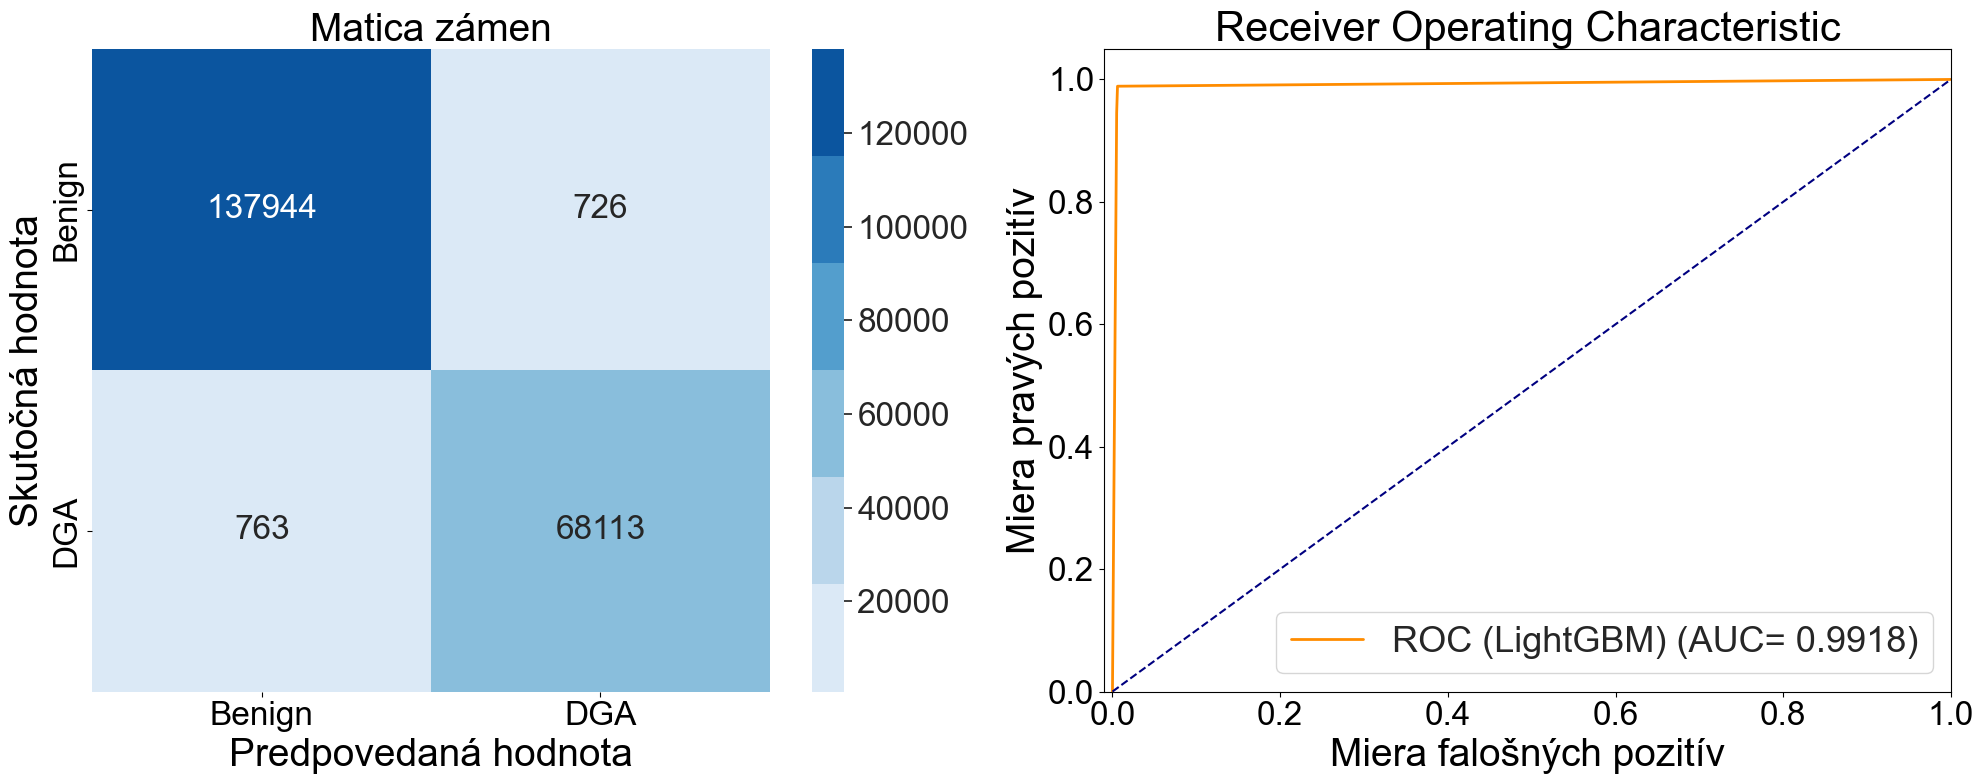

In [10]:
import lightgbm as lgbm
from joblib import dump
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the parameters
params = {
    "objective": "binary",  # Specifies the task as binary classification
    "boosting_type": "gbdt",  # Uses Gradient Boosting Decision Tree algorithm
    # The minimum number of data points to be in a leaf node before a split can be performed
    "min_child_samples": 25,
    # Fraction of features (columns) to use at each iteration
    "colsample_bytree": 1,
    # Lambda parameter for L2 regularization to avoid overfitting by penalizing large values of the coefficients.
    "reg_lambda": 0.45,
    # Subsampling ratio of the training instances, used to speed up training and prevent overfitting
    "subsample": 0.85,
    # Frequency for subsampling, set to perform subsampling at every boosting iteration.
    "subsample_freq": 1,
    # Number of subsamples for constructing histogram bins for features, affects the speed of the algorithm.
    "subsample_for_bin": 200000,
    # The minimum loss reduction required to make a further partition on a leaf node
    "min_split_gain": 0.01,
    "n_estimators": 1050,  # Number of boosting rounds or trees to build
    "max_depth": 12,  # Maximum depth of each tree, used to control overfitting as higher depth will allow model to learn relations very specific to a particular sample
    # Maximum number of leaves per tree, a critical parameter to control model complexity
    "num_leaves": 30,
    # Shrinks the contribution of each tree by this factor, a lower rate requires more trees but can lead to better models
    "learning_rate": 0.075,
    # Balancing of positive and negative weights, useful for unbalanced class scenarios
    "scale_pos_weight": 1.5,
    "metric": [
        "error",
        "binary_logloss",
        "auc",
    ],  # Metrics for evaluating the model's performance
}

# Create LightGBM model with specified parameters
model = lgbm.LGBMClassifier(**params, n_jobs=-1, random_state=27939)

# StratifiedKFold provides train/test indices to split data in train/test sets.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")

# Train the model on entire dataset
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Output the results of cross-validation
print("\n\nF1 per fold: ", scores)
print("Average F1: ", scores.mean())

# Print classification report
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix and ROC curve
plot_combined(
    y_test,
    y_pred,
    classes=["Benign", "DGA"],
    classifier_label="LightGBM",
)

# Neural Network


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Fold 1: Precision = 0.9950588345527649, Recall = 0.9867807626724243, AUC = 0.9995265603065491


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Fold 2: Precision = 0.9919476509094238, Recall = 0.9899385571479797, AUC = 0.9993249773979187


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Fold 3: Precision = 0.9914930462837219, Recall = 0.9899383783340454, AUC = 0.9993172883987427


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Fold 4: Precision = 0.9921864867210388, Recall = 0.99004727602005, AUC = 0.9995003342628479


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Fold 5: Precision = 0.9941278100013733, Recall = 0.9881089925765991, AUC = 0.9995132088661194


c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc: 0.9873 - loss: 0.1102 - precision: 0.9672 - recall: 0.9471 - val_auc: 0.9980 - val_loss: 0.0442 - val_precision: 0.9843 - val_recall: 0.9855
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9980 - loss: 0.0445 - precision: 0.9885 - recall: 0.9808 - val_auc: 0.9982 - val_loss: 0.0411 - val_precision: 0.9871 - val_recall: 0.9840
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9983 - loss: 0.0418 - precision: 0.9891 - recall: 0.9821 - val_auc: 0.9985 - val_loss: 0.0405 - val_precision: 0.9855 - val_recall: 0.9852
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9985 - loss: 0.0400 - precision: 0.9893 - recall: 0.9829 - val_auc: 0.9986 - val_loss: 0.0388 - val_precision: 0.9847 - val_recall: 0.9874
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9985 - loss: 0.0395 - precision: 0.9890 - recall: 0.9833 - val_auc: 0.9987 - val_loss: 0.0374 - val_precision: 0.9865 - val_

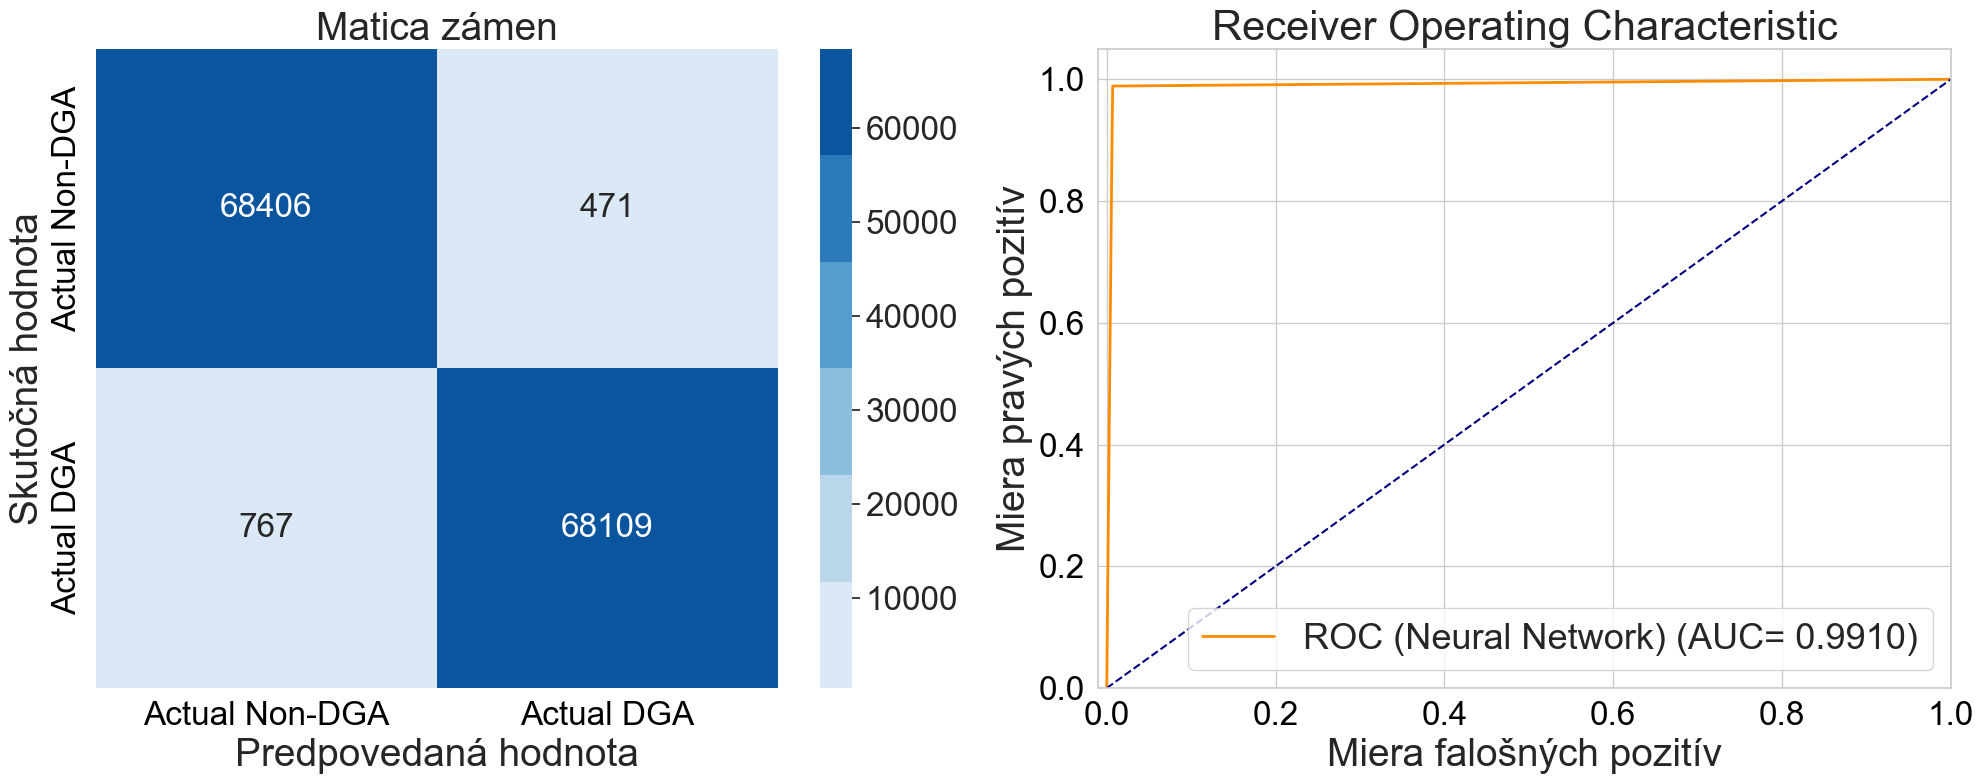

In [11]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Set the number of threads for inter-op parallelism
tf.config.threading.set_inter_op_parallelism_threads(0)

# Set the number of threads for intra-op parallelism
tf.config.threading.set_intra_op_parallelism_threads(0)


# Model definition
def create_model():
    nn = Sequential(
        [
            Dense(64, activation="relu", input_shape=(features.shape[1],)),
            Dropout(0.15),
            Dense(64, activation="relu"),
            Dropout(0.15),
            Dense(64, activation="relu"),
            Dropout(0.15),
            Dense(64, activation="relu"),
            Dropout(0.15),
            Dense(32, activation="relu"),
            Dropout(0.1),
            Dense(1, activation="sigmoid"),
        ]
    )
    nn.summary()

    nn.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=[Precision(name="precision"), Recall(name="recall"), AUC(name="auc")],
    )
    return nn


# Define seed
seed = 42

# Data preparation
min_rows = min(len(dga), len(benign))
dga_truncated = dga[:min_rows]
benign_truncated = benign[:min_rows]
data = pa.concat_tables([dga_truncated, benign_truncated])
nn_df = data.to_pandas()

# Train-Test split and normalization
class_map = {"benign": 0, "dga": 1}
labels = nn_df["label"].apply(lambda x: class_map[x])  # y vector
features = nn_df.drop("label", axis=1).copy()  # X matrix

# Normalise the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=seed, shuffle=True, stratify=labels
)

# Set seed on Tensorflow, Keras, Numpy
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

# Initialize cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
fold_no = 1

# Lists to store metrics for each fold
precision_scores = []
recall_scores = []
auc_scores = []

for train_index, test_index in cv.split(features, labels):
    X_train_fold, X_test_fold = features.iloc[train_index], features.iloc[test_index]
    y_train_fold, y_test_fold = labels.iloc[train_index], labels.iloc[test_index]

    # Create and compile model
    nn = create_model()
    history = nn.fit(
        X_train_fold,
        y_train_fold,
        batch_size=127,
        epochs=290,
        validation_data=(X_test_fold, y_test_fold),
        verbose=0,
    )

    # Evaluate the model on the test data
    scores = nn.evaluate(X_test_fold, y_test_fold, verbose=0)
    precision_scores.append(scores[1])
    recall_scores.append(scores[2])
    auc_scores.append(scores[3])

    print(
        f"Fold {fold_no}: Precision = {scores[1]}, Recall = {scores[2]}, AUC = {scores[3]}"
    )
    fold_no += 1

# Shuffle
nn_x_train, nn_y_train = shuffle(X_train, y_train, random_state=seed)

# Train the model on entire dataset
nn = create_model()
nn.fit(nn_x_train, nn_y_train, batch_size=127, epochs=290, validation_split=0.1)

# Prediction
y_pred_prob = nn.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)

# Print the fold results
print("\n\nAverage Precision across all folds:", np.mean(precision_scores))
print("Average Recall across all folds:", np.mean(recall_scores))
print("Average AUC across all folds:", np.mean(auc_scores))

plot_combined(
    y_test, y_pred, ["Actual Non-DGA", "Actual DGA"], classifier_label="Neural Network"
)